In [1]:
# Import modules
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
import torch # torch 1.12.1
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Set random seed and device
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Define hyperparameters
hyperparameters = {
    "seed": 45,
    "data_name": "toy_classification_clean3.csv",
    "data_path": "./data/",
    "batch_size": 8,
    "learning_rate": 5e-4,
    "epochs": 300,
    "activation": "gelu",
    "hidden_size": [32, 32, 32, 32, 32, 32, 2],
    "dropout": 0.0,
    "colors": {0.0: "red", 1.0: "blue"},
    "fgsm_eps": 5.0,
}
hyperparameters["data_path"] += hyperparameters["data_name"]
print("Hyperparameters:", hyperparameters)

# Set seed
set_seed(hyperparameters["seed"])
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Hyperparameters: {'seed': 45, 'data_name': 'toy_classification_clean3.csv', 'data_path': './data/toy_classification_clean3.csv', 'batch_size': 8, 'learning_rate': 0.0005, 'epochs': 300, 'activation': 'gelu', 'hidden_size': [32, 32, 32, 32, 32, 32, 2], 'dropout': 0.0, 'colors': {0.0: 'red', 1.0: 'blue'}, 'fgsm_eps': 5.0}
Current device: cuda:3


Loading data from ./data/toy_classification_clean3.csv:   0%|          | 0/100 [00:00<?, ?it/s]

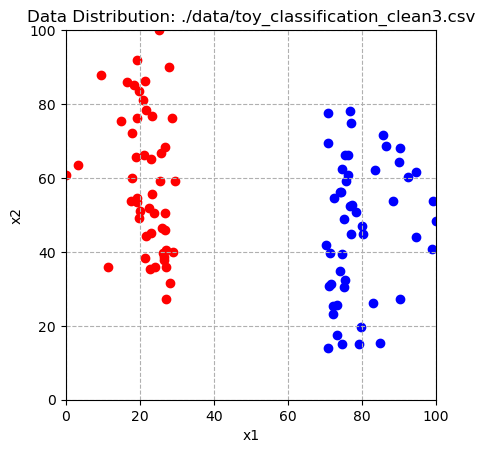

ToyModel(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=32, out_features=2, bias=True)
    (13): GELU(approximate='none')
  )
)


In [2]:
# Define the dataset
class ToyDataset(Dataset):
    def __init__(self, data_path: str) -> None:
        self.data_path = data_path
        self.dataframe = pd.read_csv(data_path)
        
        self.data_list = []
        for idx in tqdm(range(len(self.dataframe)), desc=f'Loading data from {data_path}'):
            self.data_list.append({
                'input': torch.tensor(self.dataframe.iloc[idx, 0:2].values, dtype=torch.float),
                'label': torch.tensor(int(self.dataframe.iloc[idx, 2]), dtype=torch.long),
                'aug': torch.tensor(int(self.dataframe.iloc[idx, 3]), dtype=torch.long),
                'index': idx
            })
        
        self.show_data()
    
    def rebuild(self) -> None:
        """
        Rebuild the dataset from the dataframe. This is useful when the dataset is modified.
        """
        self.data_list = []
        for idx in tqdm(range(len(self.dataframe)), desc=f'Reloading data from dataframe'):
            self.data_list.append({
                'input': torch.tensor(self.dataframe.iloc[idx, 0:2].values, dtype=torch.float),
                'label': torch.tensor(int(self.dataframe.iloc[idx, 2]), dtype=torch.long),
                'aug': torch.tensor(int(self.dataframe.iloc[idx, 3]), dtype=torch.long),
                'index': idx
            })
    
    def __getitem__(self, index: int) -> dict:
        return self.data_list[index]
    
    def __len__(self) -> int:
        return len(self.data_list)

    def show_data(self) -> None:
        # Visualize the normalized data
        fig, ax = plt.subplots()
        for i in range(len(self.dataframe)):
            if self.dataframe.iloc[i, 3] == 0:
                ax.scatter(self.dataframe.iloc[i, 0], self.dataframe.iloc[i, 1],
                           c=hyperparameters["colors"][self.dataframe.iloc[i, 2]], marker="o")
            else:
                ax.scatter(self.dataframe.iloc[i, 0], self.dataframe.iloc[i, 1],
                           c=hyperparameters["colors"][self.dataframe.iloc[i, 2]], marker="^")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_title(f"Data Distribution: {self.data_path}")
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_aspect("equal")
        ax.grid(True, which="both", ls="--")
        plt.show()

# Define the model
class ToyModel(nn.Module):
    def __init__(self) -> None:
        super(ToyModel, self).__init__()
        self.linears = nn.ModuleList()

        for i in range(len(hyperparameters['hidden_size'])):
            if i == 0:
                self.linears.append(nn.Linear(2, hyperparameters['hidden_size'][i]))
            else:
                self.linears.append(nn.Linear(hyperparameters['hidden_size'][i-1], hyperparameters['hidden_size'][i]))
            
            if hyperparameters['activation'] == "relu":
                self.linears.append(nn.ReLU())
            elif hyperparameters['activation'] == "tanh":
                self.linears.append(nn.Tanh())
            elif hyperparameters['activation'] == "sigmoid":
                self.linears.append(nn.Sigmoid())
            elif hyperparameters['activation'] == "gelu":
                self.linears.append(nn.GELU())
            else:
                raise ValueError(f"Invalid activation function: {hyperparameters['activation']}")
            
            if hyperparameters['dropout'] > 0:
                self.linears.append(nn.Dropout(hyperparameters['dropout']))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.linears:
            x = layer(x)

        return x

# Initialize the dataset and model
dataset = ToyDataset(hyperparameters['data_path'])
model = ToyModel().to(device)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

Training:   0%|          | 0/300 [00:00<?, ?it/s]

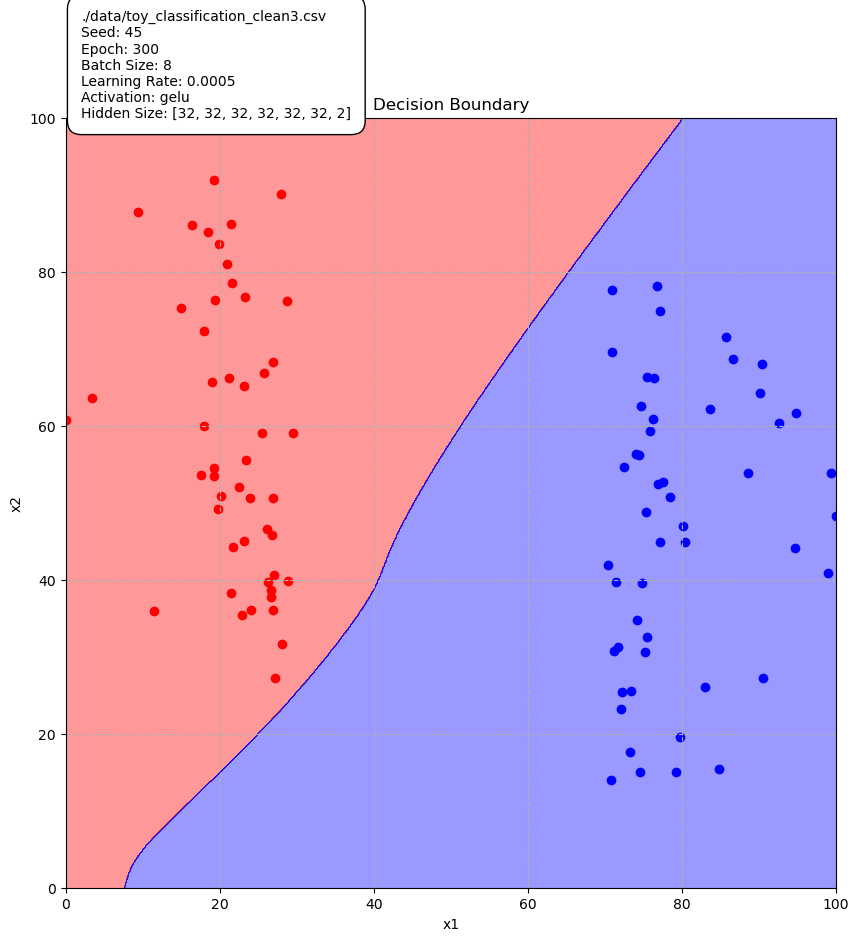

In [3]:
# Define the visualization function
def visualize_decision_boundary(model: nn.Module, dataset: ToyDataset, device: torch.device, 
                                title: str = "Decision Boundary", save_file_path: str = None) -> None:
    # Visualize the decision boundary
    x1, x2 = np.meshgrid(np.arange(0, 100, 0.1), np.arange(0, 100, 0.1))
    X = np.c_[x1.ravel(), x2.ravel()]
    X = torch.tensor(X, dtype=torch.float).to(device)
    with torch.no_grad():
        y = model(X)
    y = y.argmax(1).cpu().numpy()
    y = y.reshape(x1.shape)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    ax.contourf(x1, x2, y, alpha=0.4, cmap=ListedColormap(hyperparameters['colors'].values()))
    for i in range(len(dataset.dataframe)):
        if dataset.dataframe.iloc[i, 3] == 0:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="o")
        else:
            ax.scatter(dataset.dataframe.iloc[i, 0], dataset.dataframe.iloc[i, 1],
                        c=hyperparameters["colors"][dataset.dataframe.iloc[i, 2]], marker="^")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_title(title)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_aspect("equal")
    ax.grid(True, which="both", ls="--")

    ax.text(2, 100, 
            # Multi-line text
            f"{hyperparameters['data_path']}\n" + \
            f"Seed: {hyperparameters['seed']} \n" + \
            f"Epoch: {hyperparameters['epochs']} \n" + \
            f"Batch Size: {hyperparameters['batch_size']} \n" + \
            f"Learning Rate: {hyperparameters['learning_rate']} \n" + \
            f"Activation: {hyperparameters['activation']} \n" + \
            #f"Dropout: {hyperparameters['dropout']} \n" + \
            f"Hidden Size: {hyperparameters['hidden_size']}",
            
            fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1')
    )

    if save_file_name is not None:
        plt.savefig(save_file_name)

    plt.show()

# Define the training function
def train(model: nn.Module, dataset: ToyDataset, criterion: nn.Module, optimizer: optim.Optimizer, 
          batch_size: int, epochs: int, device: torch.device) -> None:
    # Initialize the dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss_list = []
    acc_list = []
    
    # Train the model
    for epoch in tqdm(range(epochs), desc=f"Training"):
        epoch_loss = 0
        epoch_acc = 0
        for batch in dataloader:
            # Get the inputs and labels
            inputs = batch['input'].to(device)
            labels = batch['label'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = (outputs.argmax(1) == labels).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            # Backward pass
            loss.backward()
            # Update the parameters
            optimizer.step()
        
        # Calculate the average loss and accuracy
        epoch_loss /= len(dataloader)
        epoch_acc /= len(dataloader)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)
    
    """
    # Visualize the loss and accuracy in one figure
    fig, ax = plt.subplots()
    ax.plot(loss_list, label="Loss")
    ax.plot(acc_list, label="Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss/Accuracy")
    ax.set_title(f"Loss/Accuracy Curve")
    ax.set_xlim(0, epochs)
    ax.set_ylim(0, 1)
    ax.grid(True, which="both", ls="--")
    ax.legend()
    plt.show()
    """

# Train the model
train(model, dataset, criterion, optimizer, hyperparameters['batch_size'], hyperparameters['epochs'], device)

# Visualize the decision boundary after training
timestep = time.strftime('%Y-%b-%d-%H:%M:%S', time.localtime())
save_file_name = f"{hyperparameters['data_name'][:-4]}_{timestep}.png"
save_file_path = os.path.join("./output/", save_file_name)
visualize_decision_boundary(model, dataset, device, save_file_path=save_file_path)

In [4]:
# Apply FGSM attack to generate adversarial examples
"""
def fgsm_attack(model: nn.Module, dataset: ToyDataset, criterion: nn.Module, epsilon: float, device: torch.device) -> None:
    # Find maximum value of the 4th column in the dataset -> Last augmentation session
    last_aug_session = dataset.dataframe.iloc[:, 3].max()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Generate adversarial examples
    for batch in dataloader:
        # Get the inputs and labels
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)
        fliped_labels = (labels + 1) % 2 # Flip the labels (0 -> 1, 1 -> 0)

        aug_session = batch['aug'].to(device)
        if aug_session.item() != last_aug_session:
            continue # Skip the example if it is not the last augmentation session
        
        # Zero the parameter gradients
        inputs.requires_grad = True
        
        # Forward pass
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1) # Apply softmax to the outputs
        loss = criterion(outputs, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Collect the element-wise sign of the data gradient
        data_grad = inputs.grad.data.sign()
        
        # Create the adversarial example
        perturbed_inputs = inputs + epsilon * data_grad
        perturbed_inputs = torch.clamp(perturbed_inputs, 0, 100) # Clamp all values in the tensor into the range [0, 100]
        
        # Get the adversarial example
        with torch.no_grad():
            adversarial_outputs = model(perturbed_inputs)
            adversarial_probs = F.softmax(adversarial_outputs, dim=1) # Apply softmax to the outputs
            if adversarial_probs.max(1)[0].item() > probs.max(1)[0].item(): # If the adversarial example is more confident
                print(f"Found: {adversarial_probs.max(1)[0].item():.2f} > {probs.max(1)[0].item():.2f}")
                # Change the sign of the data gradient and create the adversarial example
                perturbed_inputs = inputs - epsilon * data_grad
                perturbed_inputs = torch.clamp(perturbed_inputs, 0, 100) # Clamp all values in the tensor into the range [0, 100]
                adversarial_outputs = model(perturbed_inputs)
                adversarial_probs = F.softmax(adversarial_outputs, dim=1) # Apply softmax to the outputs

        
        # Get the adversarial example
        adversarial_inputs = perturbed_inputs.cpu().detach().numpy()
        adversarial_labels = labels.cpu().detach().numpy() # Retain original label 
        #adversarial_labels = adversarial_outputs.argmax(1).cpu().detach().numpy() # Retain predicted label
        
        # Add the adversarial example to the dataset
        dataset.dataframe = dataset.dataframe.append(pd.DataFrame([[adversarial_inputs[0][0], adversarial_inputs[0][1], 
                                                                    adversarial_labels[0], last_aug_session+1]], 
                                                                   columns=dataset.dataframe.columns), ignore_index=True)
"""
def fgsm_attack(model: nn.Module, dataset: ToyDataset, criterion: nn.Module, epsilon: float, device: torch.device) -> None:
    # Find maximum value of the 4th column in the dataset -> Last augmentation session
    last_aug_session = dataset.dataframe.iloc[:, 3].max()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # Generate adversarial examples
    for batch in dataloader:
        # Get the inputs and labels
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)
        fliped_labels = (labels + 1) % 2 # Flip the labels (0 -> 1, 1 -> 0)

        aug_session = batch['aug'].to(device)
        if aug_session.item() != last_aug_session:
            continue # Skip the example if it is not the last augmentation session
        
        # Zero the parameter gradients
        inputs.requires_grad = True
        
        # Forward pass
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1) # Apply softmax to the outputs
        loss = criterion(outputs, fliped_labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Collect the element-wise sign of the data gradient
        data_grad = inputs.grad.data.sign()
        
        # Create the adversarial example
        perturbed_inputs = inputs - epsilon * data_grad
        perturbed_inputs = torch.clamp(perturbed_inputs, 0, 100) # Clamp all values in the tensor into the range [0, 100]
        
        # Get the adversarial example
        with torch.no_grad():
            adversarial_outputs = model(perturbed_inputs)
            adversarial_probs = F.softmax(adversarial_outputs, dim=1) # Apply softmax to the outputs
            if adversarial_probs.max(1)[0].item() > probs.max(1)[0].item(): # If the adversarial example is more confident
                print(f"Found: {adversarial_probs.max(1)[0].item():.2f} > {probs.max(1)[0].item():.2f}")
                # Change the sign of the data gradient and create the adversarial example
                perturbed_inputs = inputs + epsilon * data_grad
                perturbed_inputs = torch.clamp(perturbed_inputs, 0, 100) # Clamp all values in the tensor into the range [0, 100]
                adversarial_outputs = model(perturbed_inputs)
                adversarial_probs = F.softmax(adversarial_outputs, dim=1) # Apply softmax to the outputs

        
        # Get the adversarial example
        adversarial_inputs = perturbed_inputs.cpu().detach().numpy()
        adversarial_labels = labels.cpu().detach().numpy() # Retain original label 
        #adversarial_labels = adversarial_outputs.argmax(1).cpu().detach().numpy() # Retain predicted label
        
        # Add the adversarial example to the dataset
        dataset.dataframe = dataset.dataframe.append(pd.DataFrame([[adversarial_inputs[0][0], adversarial_inputs[0][1], 
                                                                    adversarial_labels[0], last_aug_session+1]], 
                                                                   columns=dataset.dataframe.columns), ignore_index=True)

# Generate adversarial examples
fgsm_attack(model, dataset, criterion, hyperparameters['fgsm_eps'], device)


/tmp/ipykernel_27295/3462816713.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset.dataframe = dataset.dataframe.append(pd.DataFrame([[adversarial_inputs[0][0], adversarial_inputs[0][1],


Found: 1.00 > 1.00


Reloading data from dataframe:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

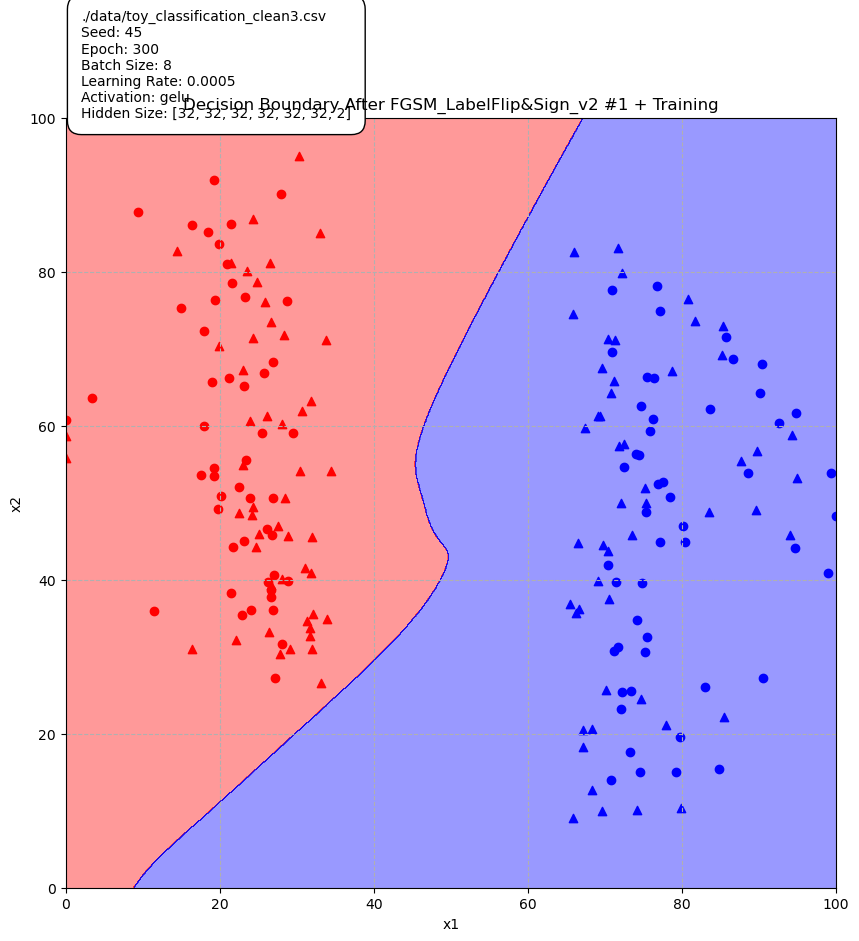

/tmp/ipykernel_27295/3462816713.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset.dataframe = dataset.dataframe.append(pd.DataFrame([[adversarial_inputs[0][0], adversarial_inputs[0][1],


Reloading data from dataframe:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

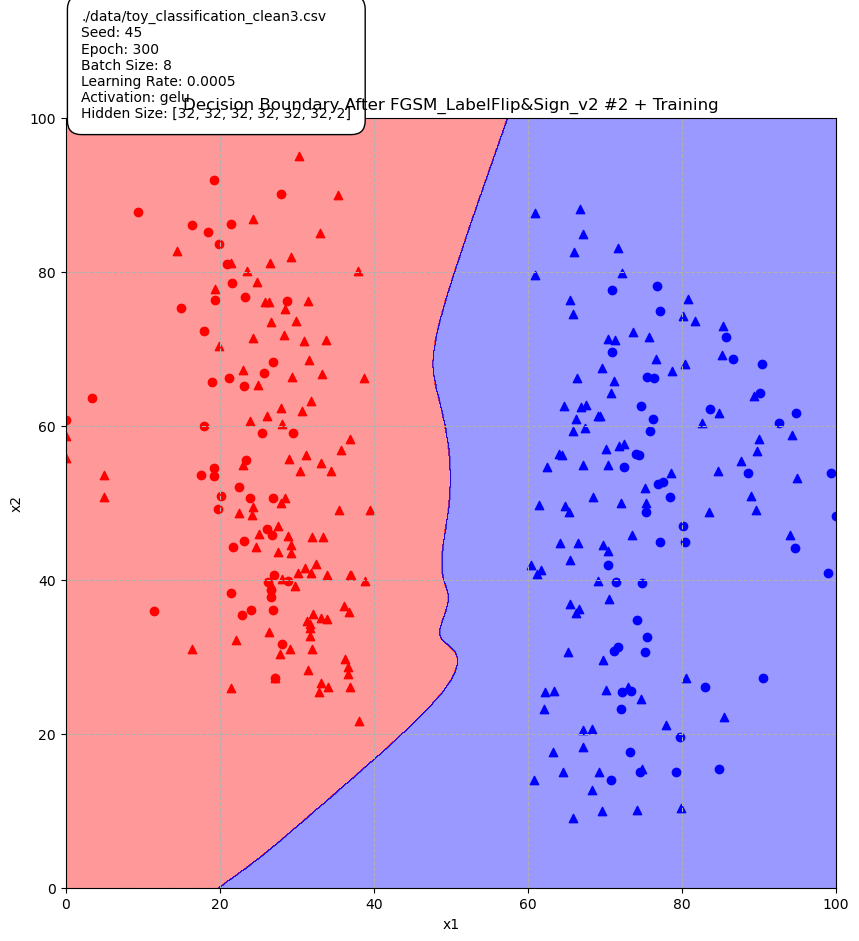

Reloading data from dataframe:   0%|          | 0/400 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

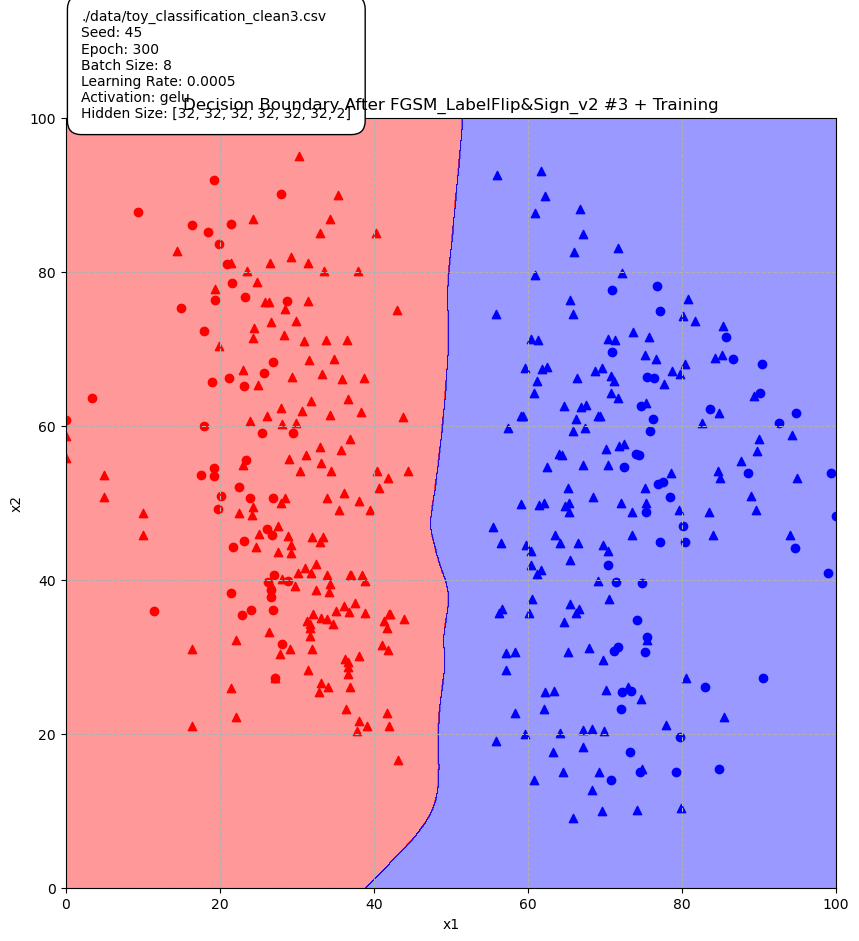

Reloading data from dataframe:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

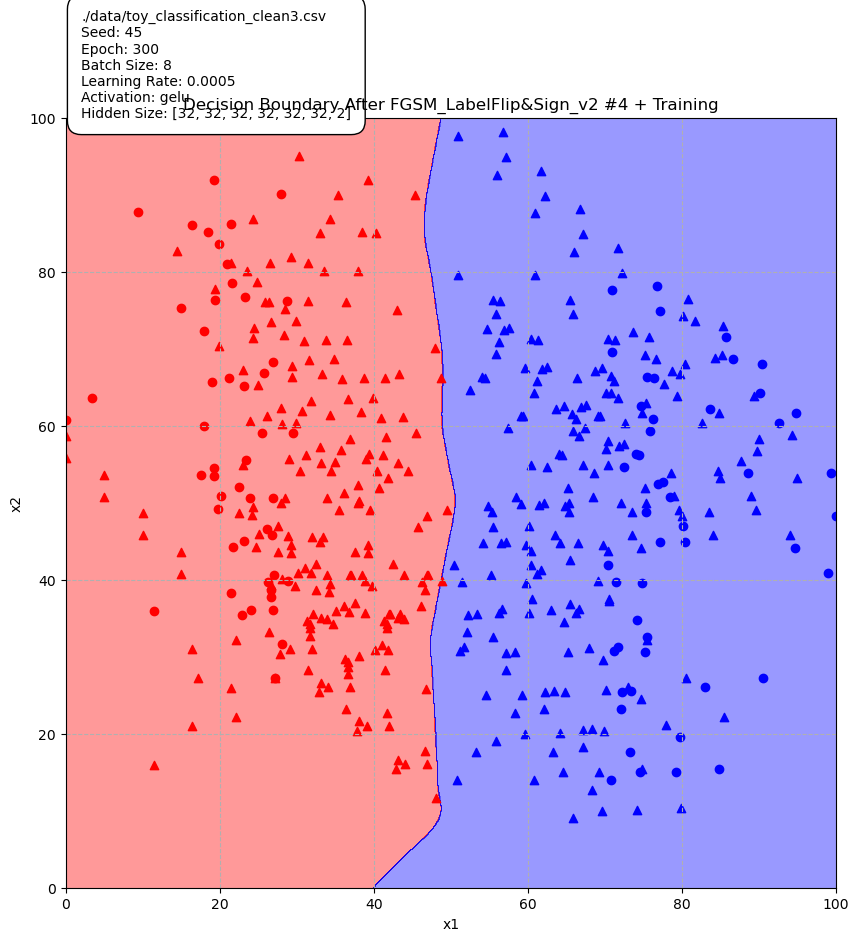

Found: 1.00 > 1.00
Found: 1.00 > 0.96
Found: 0.98 > 0.97
Found: 1.00 > 0.97
Found: 1.00 > 0.91
Found: 1.00 > 0.57
Found: 1.00 > 0.99
Found: 1.00 > 0.80
Found: 0.99 > 0.73
Found: 0.99 > 0.57
Found: 0.99 > 0.88
Found: 0.99 > 0.99
Found: 1.00 > 0.83
Found: 1.00 > 0.97
Found: 0.99 > 0.97
Found: 1.00 > 0.66
Found: 0.98 > 0.97
Found: 0.99 > 0.91


Reloading data from dataframe:   0%|          | 0/600 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

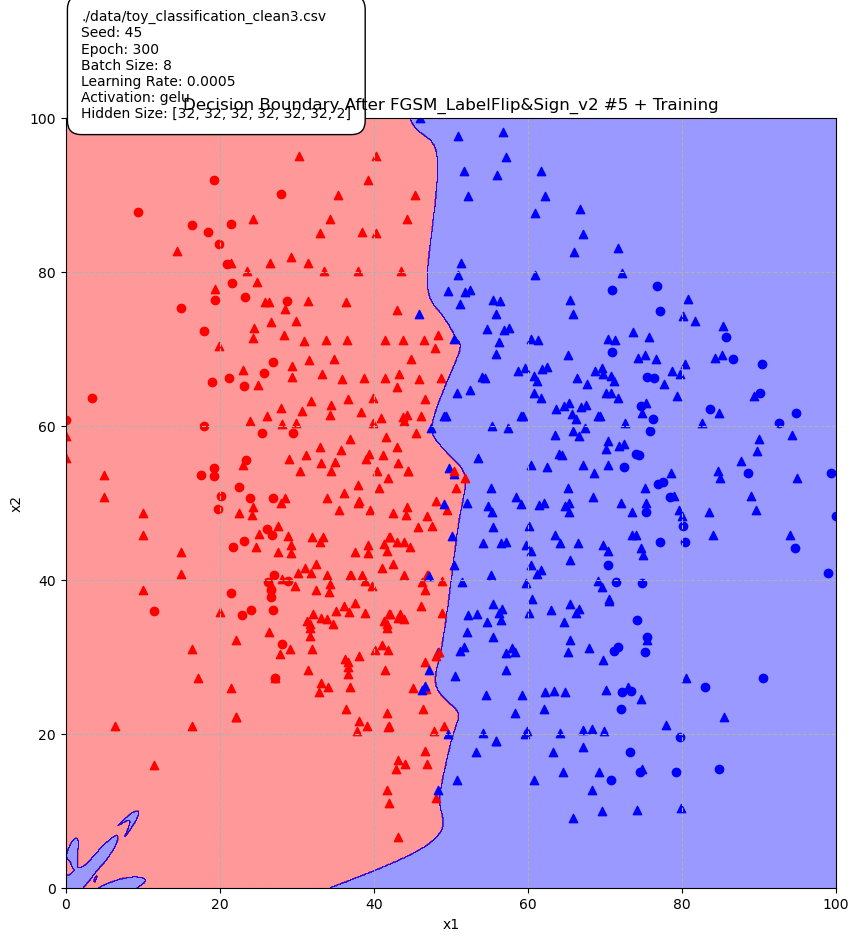

Found: 0.99 > 0.85
Found: 0.96 > 0.60
Found: 1.00 > 0.83
Found: 0.93 > 0.83
Found: 1.00 > 0.53
Found: 0.83 > 0.68
Found: 0.99 > 0.95
Found: 1.00 > 0.52
Found: 0.97 > 0.78
Found: 0.75 > 0.62
Found: 1.00 > 0.83
Found: 0.98 > 0.63
Found: 0.96 > 0.54
Found: 0.92 > 0.81
Found: 0.92 > 0.82
Found: 0.83 > 0.76
Found: 0.93 > 0.80
Found: 0.99 > 0.58
Found: 1.00 > 0.64
Found: 0.77 > 0.72
Found: 0.95 > 0.86
Found: 1.00 > 0.57
Found: 1.00 > 0.65
Found: 0.94 > 0.65
Found: 0.96 > 0.77
Found: 1.00 > 0.70
Found: 1.00 > 1.00
Found: 0.98 > 0.62
Found: 0.96 > 0.59
Found: 0.98 > 0.96
Found: 0.97 > 0.84
Found: 0.98 > 0.51
Found: 0.93 > 0.57
Found: 1.00 > 0.55
Found: 0.98 > 0.61


In [5]:
for i in range(5):
    # Train again with adversarial examples
    dataset.rebuild() # Rebuild the dataset to include the adversarial examples

    # Train the model
    train(model, dataset, criterion, optimizer, hyperparameters['batch_size'], hyperparameters['epochs'], device)

    # Visualize the decision boundary after training
    timestep = time.strftime('%Y-%b-%d-%H:%M:%S', time.localtime())
    save_file_name = f"{hyperparameters['data_name'][:-4]}_{timestep}_fgsm{i+1}.png"
    save_file_path = os.path.join("./output/", save_file_name)
    visualize_decision_boundary(model, dataset, device, 
                                title=f"Decision Boundary After FGSM_LabelFlip&Sign_v2 #{i+1} + Training",
                                save_file_path=save_file_path)

    # Apply FGSM attack to generate adversarial examples
    fgsm_attack(model, dataset, criterion, hyperparameters['fgsm_eps'], device)